
Improve the performance of the model using one (or both) of the proposed techniques:

1) Hyperparameter tuning

Use one of the keras tuner hyperparameter search methods in order to improve the performance of the network. Implement it in such a way, that also the number of layers of the network (the architecture) is a hyperparameter.

Things to consider are:
- To add additional set of Conv2D/MaxPooling/Dropout layers with more neurons
- To use twin Conv2D layers of the same number of neurons:
```
Conv2D
Conv2D
MaxPooling
Dropout
```
- To experiment with different optimizers

This link will be usefull: https://keras.io/guides/keras_tuner/getting_started/
And this: https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

2) Data augumentation

Further reading on data augmentation:
https://www.datacamp.com/tutorial/complete-guide-data-augmentation

Provide a link to your colab notebook by mail (grega@agh.edu.pl) by 16th May 2023. Please provide your name in your notebook file name.

Competition: The highest accuracy on test set wins!

This homework is compulsory.

In [1]:
!wget -nc https://raw.githubusercontent.com/MenosGrandes/AI_ML_Course/main/requirements.txt
!pip install keras-tuner

File ‘requirements.txt’ already there; not retrieving.



In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

!pip install -r requirements.txt
import platform
import sys


# define Seaborn color palette to use
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
)
import keras_tuner as kt

2024-05-09 13:07:42.468132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-09 13:07:42.470308: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:07:42.612753: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-09 13:07:43.149460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-09 13:07:44.930664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
import logging

from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level="NOTSET", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)

logger = logging.getLogger("rich")

In [4]:
VERBOSE_LOGGING = True

In [5]:
v = platform.python_version_tuple()
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

# warnings.filterwarnings("ignore", "is_categorical_dtype")
# warnings.filterwarnings("ignore", "use_inf_as_na")
np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_colwidth = 1000

# LIBRARY CODE Start

In [6]:
from collections import namedtuple
from typing import NamedTuple

TupleD = namedtuple("TupleD", "x y")
MLData = namedtuple("MLData", "train_data valid_data")


# Hyperparameters!
class HyperParameters(NamedTuple):
    droputs: float
    output_layers: int
    epochs: int
    bach_size: int
    input_dim: int
    optimizer: keras.optimizers.Optimizer
    loss_f: keras.losses.Loss
    output_layer_activation_f: keras.layers.Activation


class ModelWrapper:
    def __init__(self, name, model, _valid_data, hyperparams):
        self.__model = model
        self.__valid_data = _valid_data
        self.__name = name
        self.__hyperparameters = hyperparams
        self.__is_fit = False

    def __pred(self):
        self.__y_valid_pred = np.argmax(
            self.__model.predict(self.__valid_data.x), axis=1
        )

    def plot_confusion_matrix(self):
        _cm = confusion_matrix(self.__valid_data.y, self.__y_valid_pred)
        _cmp = ConfusionMatrixDisplay(
            confusion_matrix=_cm,
            display_labels=list(range(len(np.unique(self.__valid_data.y)))),
        )
        _fig, _ax = plt.subplots(figsize=(8, 8))
        _cmp.plot(ax=_ax)
        _fig.show()

    def plot_overfitting(self):
        plt.figure(figsize=(13, 5))
        plt.plot(self.__history.history["accuracy"])
        plt.plot(self.__history.history["val_accuracy"])
        plt.title("Model Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Test"])
        plt.grid()
        plt.show()

    def summarise(self):
        if self.__is_fit is True:
            logger.info(f"{self.__name} | Model summary:\n")
            self.__model.summary()
            logger.info(f"{self.__name} | Classification report: \n")
            logger.info(
                f"{classification_report(self.__valid_data.y, self.__y_valid_pred)}"
            )

            self.plot_confusion_matrix()
            self.plot_overfitting()
        else:
            logger.error("You should fit model first!")

    def fit(self, __train_data):
        logger.info(f"{self.__name} | Model fitting!")

        self.__history = self.__model.fit(
            __train_data.x,
            __train_data.y,
            batch_size=self.__hyperparameters.bach_size,
            epochs=self.__hyperparameters.epochs,
            validation_data=(self.__valid_data.x, self.__valid_data.y),
            verbose=VERBOSE_LOGGING,
        )
        self.__pred()
        self.__is_fit = True

# LIBRARY CODE End

In [7]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(class_names)

# https://www.tensorflow.org/datasets/catalog/cifar10

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
model = keras.Sequential()
model.add(
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3))
)
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

/home/mg/.virtualenvs/AI/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Add your network structure here
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.2370 - loss: 1.9999 - val_accuracy: 0.4620 - val_loss: 1.5221
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.4181 - loss: 1.5624 - val_accuracy: 0.5420 - val_loss: 1.3076
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.4593 - loss: 1.4412 - val_accuracy: 0.5558 - val_loss: 1.2494
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.4893 - loss: 1.3661 - val_accuracy: 0.6000 - val_loss: 1.1462
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5095 - loss: 1.3148 - val_accuracy: 0.6183 - val_loss: 1.1066


[13:09:51] DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.         ]8;id=860870;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py\pyplot.py]8;;\:]8;id=814209;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py#414\414]8;;\

           DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.         ]8;id=996389;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py\pyplot.py]8;;\:]8;id=666919;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py#414\414]8;;\

           DEBUG    findfont: Matching                                                         ]8;id=683865;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=155246;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1411\1411]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    10.0.                                                                                          

           DEBUG    findfont:                                                                  ]8;id=860324;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=792356;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu                     
                    Serif', style='italic', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=595586;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=677650;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral',                         
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=581202;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=95936;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf',                                       
                    name='STIXSizeFiveSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=41747;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=462248;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal',                     
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=288568;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=38711;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu                           
                    Serif', style='normal', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=699180;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=181986;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu                         
                    Serif Display', style='normal', variant='normal', weight=400,                                  
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=8800;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=225842;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf',                              
                    name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=395492;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=901516;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans',                          
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 0.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=814168;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=971248;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf',                                        
                    name='STIXSizeOneSym', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=710393;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=588082;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans                     
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=675941;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=129285;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf',                                       
                    name='STIXGeneral', style='italic', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=269629;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=46936;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu                         
                    Sans', style='oblique', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 1.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=293823;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=566899;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu                     
                    Sans', style='oblique', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 1.335                                                                      

           DEBUG    findfont:                                                                  ]8;id=457470;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=814110;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans',                     
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 0.33499999999999996                                                        

           DEBUG    findfont:                                                                  ]8;id=413013;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=414820;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif',                        
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=664368;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=90079;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu                         
                    Serif', style='italic', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=500958;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=667688;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf',                                           
                    name='STIXNonUnicode', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=817550;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=97166;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=254219;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=383666;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode',                       
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=74324;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=320248;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf',                                      
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=430537;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=314692;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=335754;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=81009;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu                        
                    Sans Mono', style='normal', variant='normal', weight=700,                                      
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=967457;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=614751;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf',                                        
                    name='STIXSizeTwoSym', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=156641;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=953483;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf',                                       
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=52263;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=994509;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu                     
                    Sans Mono', style='oblique', variant='normal', weight=400,                                     
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=447441;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=624491;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=724938;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=458599;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf',                                        
                    name='STIXSizeOneSym', style='normal', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=524665;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=22099;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=240822;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=680659;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf',                                        
                    name='STIXSizeTwoSym', style='normal', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=833484;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=958713;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf',                                        
                    name='STIXNonUnicode', style='italic', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=866678;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=675079;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans                        
                    Mono', style='normal', variant='normal', weight=400, stretch='normal',                         
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=238813;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=154066;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal',                     
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=87700;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=238742;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf',                                       
                    name='STIXGeneral', style='italic', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=693795;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=502587;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf',                                       
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=958167;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=798161;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=867614;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=759619;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf',                                      
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=700,                         
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=596010;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=441565;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=1833;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=470759;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf',                                           
                    name='STIXNonUnicode', style='italic', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=161585;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=398280;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.tt                     
                    f', name='DejaVu Sans', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 0.33499999999999996                                      

           DEBUG    findfont:                                                                  ]8;id=882665;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=156461;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=473429;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=818086;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    d.ttf', name='DejaVu Sans Mono', style='normal', variant='normal',                             
                    weight=700, stretch='normal', size='scalable')) = 10.335                                       

           DEBUG    findfont:                                                                  ]8;id=439098;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=663076;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=143916;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=228127;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',                        
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=559388;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=574050;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=539182;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=969845;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSansMono[wgh                     
                    t].ttf', name='Ubuntu Sans Mono', style='normal', variant='normal',                            
                    weight=400, stretch='normal', size='scalable')) = 10.05                                        

           DEBUG    findfont:                                                                  ]8;id=168606;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=76233;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Italic[wdth                     
                    ,wght].ttf', name='Ubuntu', style='italic', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=160077;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=367197;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=305559;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=819624;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',                      
                    name='DejaVu Serif', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=369931;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=761222;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',                       
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=284903;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=722709;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf                     
                    ', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=367463;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=5308;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=782371;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=31914;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Obl                     
                    ique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal',                         
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=642420;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=55281;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSansMono-Ita                     
                    lic[wght].ttf', name='Ubuntu Sans Mono', style='italic', variant='normal',                     
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=188732;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=912478;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.t                     
                    tf', name='DejaVu Serif', style='normal', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=605505;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=523050;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-Italic[                     
                    wght].ttf', name='Ubuntu Mono', style='italic', variant='normal',                              
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=934343;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=803359;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=818684;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=747387;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    dOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal',                     
                    weight=700, stretch='normal', size='scalable')) = 11.335                                       

           DEBUG    findfont:                                                                  ]8;id=817287;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=116141;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=644435;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=870880;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-MI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=918433;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=557673;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono[wght].t                     
                    tf', name='Ubuntu Mono', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=451898;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=826181;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

[13:09:52] DEBUG    findfont:                                                                  ]8;id=294325;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=573106;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=70113;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=176234;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu[wdth,wght].                     
                    ttf', name='Ubuntu', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=848619;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=175512;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSans-Italic[                     
                    wdth,wght].ttf', name='Ubuntu Sans', style='italic', variant='normal',                         
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=528986;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=111565;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=228978;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=77085;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=907747;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=520929;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=25396;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=234860;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSans[wdth,wg                     
                    ht].ttf', name='Ubuntu Sans', style='normal', variant='normal',                                
                    weight=400, stretch='normal', size='scalable')) = 10.05                                        

           DEBUG    findfont: Matching                                                         ]8;id=586095;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=879890;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1454\1454]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    10.0 to DejaVu Sans                                                                            
                    ('/home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/mpl-dat                     
                    a/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.                                           

           DEBUG    findfont: Matching                                                         ]8;id=145394;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=891861;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1411\1411]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    12.0.                                                                                          

           DEBUG    findfont:                                                                  ]8;id=385876;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=164116;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu                     
                    Serif', style='italic', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 11.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=490143;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=389375;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral',                         
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=609650;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=957178;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf',                                       
                    name='STIXSizeFiveSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=430200;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=802001;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal',                     
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=76492;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=823753;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu                           
                    Serif', style='normal', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=494375;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=26063;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu                         
                    Serif Display', style='normal', variant='normal', weight=400,                                  
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=959339;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=911203;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf',                              
                    name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=699216;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=62354;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans',                          
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 0.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=540759;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=881215;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf',                                        
                    name='STIXSizeOneSym', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=470896;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=92900;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans                     
                    Display', style='normal', variant='normal', weight=400, stretch='normal',                      
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=131393;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=798830;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf',                                       
                    name='STIXGeneral', style='italic', variant='normal', weight=700,                              
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=491149;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=503808;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu                         
                    Sans', style='oblique', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 1.05                                                                       

           DEBUG    findfont:                                                                  ]8;id=722017;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=624702;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu                     
                    Sans', style='oblique', variant='normal', weight=700, stretch='normal',                        
                    size='scalable')) = 1.335                                                                      

           DEBUG    findfont:                                                                  ]8;id=971038;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=845234;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans',                     
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 0.33499999999999996                                                        

           DEBUG    findfont:                                                                  ]8;id=170670;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=889932;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif',                        
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=700802;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=566242;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu                         
                    Serif', style='italic', variant='normal', weight=400, stretch='normal',                        
                    size='scalable')) = 11.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=905965;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=563422;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf',                                           
                    name='STIXNonUnicode', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=385947;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=651809;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=408698;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=24063;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode',                       
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=312877;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=987984;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf',                                      
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=120573;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=721582;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=546571;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=289509;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu                        
                    Sans Mono', style='normal', variant='normal', weight=700,                                      
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=441044;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=489186;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf',                                        
                    name='STIXSizeTwoSym', style='normal', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=997751;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=786208;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf',                                       
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=400,                          
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=795216;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=569141;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu                     
                    Sans Mono', style='oblique', variant='normal', weight=400,                                     
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=645041;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=525289;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=604769;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=942472;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf',                                        
                    name='STIXSizeOneSym', style='normal', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=563031;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=624460;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral',                      
                    style='normal', variant='normal', weight=700, stretch='normal',                                
                    size='scalable')) = 10.335                                                                     

           DEBUG    findfont:                                                                  ]8;id=310024;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=577411;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf',                                        
                    name='STIXSizeTwoSym', style='normal', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=333374;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=880623;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf',                                        
                    name='STIXNonUnicode', style='italic', variant='normal', weight=700,                           
                    stretch='normal', size='scalable')) = 11.335                                                   

           DEBUG    findfont:                                                                  ]8;id=310804;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=115097;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans                        
                    Mono', style='normal', variant='normal', weight=400, stretch='normal',                         
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=37046;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=124304;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal',                     
                    variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05                      

           DEBUG    findfont:                                                                  ]8;id=931134;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=634806;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf',                                       
                    name='STIXGeneral', style='italic', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=306543;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=163172;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf',                                       
                    name='STIXSizeFourSym', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=882017;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=241161;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=818693;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=51841;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf',                                      
                    name='STIXSizeThreeSym', style='normal', variant='normal', weight=700,                         
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=792171;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=660578;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10',                                   
                    style='normal', variant='normal', weight=400, stretch='normal',                                
                    size='scalable')) = 10.05                                                                      

           DEBUG    findfont:                                                                  ]8;id=268388;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=380547;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/home/mg/.virtualenvs/AI/lib/python3.12/site-packag                     
                    es/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf',                                           
                    name='STIXNonUnicode', style='italic', variant='normal', weight=400,                           
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=677651;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=948224;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.tt                     
                    f', name='DejaVu Sans', style='normal', variant='normal', weight=700,                          
                    stretch='normal', size='scalable')) = 0.33499999999999996                                      

           DEBUG    findfont:                                                                  ]8;id=907196;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=582533;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=325041;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=881643;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    d.ttf', name='DejaVu Sans Mono', style='normal', variant='normal',                             
                    weight=700, stretch='normal', size='scalable')) = 10.335                                       

           DEBUG    findfont:                                                                  ]8;id=986645;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=200773;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-RI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=164137;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=951382;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf',                        
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=424226;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=433874;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=517762;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=348323;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSansMono[wgh                     
                    t].ttf', name='Ubuntu Sans Mono', style='normal', variant='normal',                            
                    weight=400, stretch='normal', size='scalable')) = 10.05                                        

           DEBUG    findfont:                                                                  ]8;id=59177;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=994;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Italic[wdth                     
                    ,wght].ttf', name='Ubuntu', style='italic', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=458119;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=886887;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=420510;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=958616;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf',                      
                    name='DejaVu Serif', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=164138;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=259878;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf',                       
                    name='DejaVu Sans', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 0.05                                                     

           DEBUG    findfont:                                                                  ]8;id=712636;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=306602;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf                     
                    ', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400,                      
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=393319;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=999393;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=563456;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=309899;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Obl                     
                    ique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal',                         
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=940520;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=96220;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSansMono-Ita                     
                    lic[wght].ttf', name='Ubuntu Sans Mono', style='italic', variant='normal',                     
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=144967;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=320042;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.t                     
                    tf', name='DejaVu Serif', style='normal', variant='normal', weight=700,                        
                    stretch='normal', size='scalable')) = 10.335                                                   

           DEBUG    findfont:                                                                  ]8;id=548018;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=955393;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-Italic[                     
                    wght].ttf', name='Ubuntu Mono', style='italic', variant='normal',                              
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=158288;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=358976;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=753235;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=985988;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bol                     
                    dOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal',                     
                    weight=700, stretch='normal', size='scalable')) = 11.335                                       

           DEBUG    findfont:                                                                  ]8;id=493048;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=26990;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=989190;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=261991;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-MI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=165237;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=472268;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono[wght].t                     
                    tf', name='Ubuntu Mono', style='normal', variant='normal', weight=400,                         
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=703472;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=296008;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-RI.ttf',                        
                    name='Ubuntu', style='italic', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=384259;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=595503;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=959477;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=552081;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu[wdth,wght].                     
                    ttf', name='Ubuntu', style='normal', variant='normal', weight=400,                             
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=836252;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=236514;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSans-Italic[                     
                    wdth,wght].ttf', name='Ubuntu Sans', style='italic', variant='normal',                         
                    weight=400, stretch='normal', size='scalable')) = 11.05                                        

           DEBUG    findfont:                                                                  ]8;id=896839;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=422302;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf',                     
                    name='Ubuntu Mono', style='normal', variant='normal', weight=400,                              
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=112624;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=721011;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf',                         
                    name='Ubuntu', style='normal', variant='normal', weight=400,                                   
                    stretch='normal', size='scalable')) = 10.05                                                    

           DEBUG    findfont:                                                                  ]8;id=970663;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=196704;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf'                     
                    , name='Ubuntu Mono', style='italic', variant='normal', weight=400,                            
                    stretch='normal', size='scalable')) = 11.05                                                    

           DEBUG    findfont:                                                                  ]8;id=49605;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=285951;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1423\1423]8;;\
                    score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuSans[wdth,wg                     
                    ht].ttf', name='Ubuntu Sans', style='normal', variant='normal',                                
                    weight=400, stretch='normal', size='scalable')) = 10.05                                        

           DEBUG    findfont: Matching                                                         ]8;id=994032;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=750778;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/font_manager.py#1454\1454]8;;\
                    sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=                     
                    12.0 to DejaVu Sans                                                                            
                    ('/home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/mpl-dat                     
                    a/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.                                           

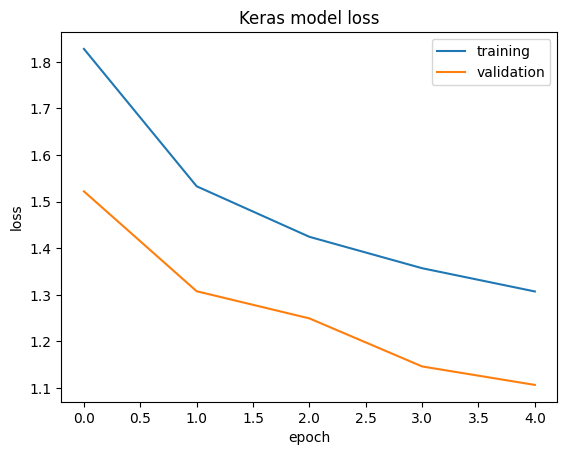

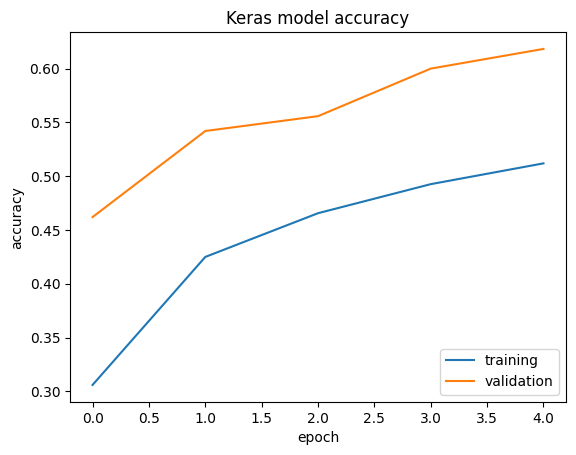

313/313 - 2s - 7ms/step - accuracy: 0.6175 - loss: 1.1151
0.6175000071525574


In [10]:
# Visualize History for Loss.
plt.title("Keras model loss")
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["training", "validation"], loc="upper right")
plt.show()

# Visualize History for Accuracy.
plt.title("Keras model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["training", "validation"], loc="lower right")
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

[13:27:35] DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.         ]8;id=698892;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py\pyplot.py]8;;\:]8;id=17657;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/pyplot.py#414\414]8;;\

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.74      0.75      1000
           1       0.76      0.85      0.80      1000
           2       0.70      0.47      0.56      1000
           3       0.46      0.58      0.52      1000
           4       0.63      0.66      0.65      1000
           5       0.62      0.60      0.61      1000
           6       0.81      0.72      0.76      1000
           7       0.70      0.83      0.76      1000
           8       0.87      0.76      0.81      1000
           9       0.77      0.76      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



[13:27:38] DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f453baa0950>               ]8;id=265353;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/colorbar.py\colorbar.py]8;;\:]8;id=725144;file:///home/mg/.virtualenvs/AI/lib/python3.12/site-packages/matplotlib/colorbar.py#859\859]8;;\

/tmp/ipykernel_872/1767854645.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


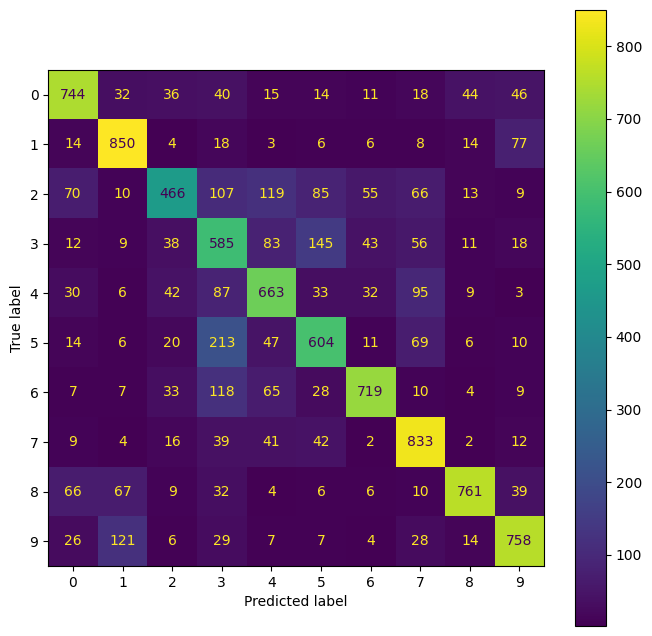

In [14]:
# classification report and confusion matrix
%matplotlib inline

y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

print(f"Classification report: \n {classification_report(y_test_decoded, y_test_pred)}")

cm = confusion_matrix(y_test_decoded, y_test_pred)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8, 8))
cmp.plot(ax=ax)
fig.show()

In [12]:
def model_builder(hp):
    model = keras.Sequential()
    activation = hp.Choice(
        name="activation", values=["relu", "tanh", "sigmoid"], ordered=False
    )
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.3, step=0.1)

    model.add(
        Conv2D(
            32, (3, 3), activation=activation, padding="same", input_shape=(32, 32, 3)
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), activation=activation, padding="same"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())

    # Tune the number of filters in the L1 layer
    # Choose an optimal value from 32 to 128 with a step of 32 (x4)
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


tuner = kt.RandomSearch(
    model_builder,
    objective="val_accuracy",
    directory="my_dir",
    project_name="intro_to_kt",
    overwrite=True,
    executions_per_trial=1,
    seed=42,
    max_trials=6,
)

tensorboard_logs = keras.callbacks.TensorBoard("/tmp/tb_logs_random")

tuner.search(
    X_train,
    y_train,
    epochs=5,
    validation_split=0.2,
    batch_size=32,
    callbacks=[tensorboard_logs],
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=5, batch_size=32)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

Trial 6 Complete [00h 02m 19s]
val_accuracy: 0.6776999831199646

Best val_accuracy So Far: 0.6988000273704529
Total elapsed time: 00h 14m 53s
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accuracy: 0.3644 - loss: 1.7327
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5974 - loss: 1.1248
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.6549 - loss: 0.9781
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.6824 - loss: 0.8990
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.7121 - loss: 0.8229
313/313 - 2s - 6ms/step - accuracy: 0.6983 - loss: 0.8712
0.6983000040054321


In [13]:
tuner.results_summary(num_trials=3)

Results summary
Results in my_dir/intro_to_kt
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
activation: relu
dropout: 0.1
Score: 0.6988000273704529

Trial 5 summary
Hyperparameters:
activation: relu
dropout: 0.2
Score: 0.6776999831199646

Trial 0 summary
Hyperparameters:
activation: tanh
dropout: 0.1
Score: 0.6743000149726868


In [16]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [19]:
%reload_ext tensorboard
%tensorboard --logdir /tmp/tb_logs_random

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=5, batch_size=32)

/home/mg/.virtualenvs/AI/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.3599 - loss: 1.7344
Epoch 2/5
 167/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.5528 - loss: 1.2577

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print(test_acc)